In [1]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
import time

In [35]:
#from sympy.physics.quantum import Commutator as comm
def comm(A,B):
    return A*B-B*A

In [2]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [897]:
delo,delm=sym.symbols('delta_o delta_mu', real=True) 
#delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False) #energy decay for atom levels
Omega=sym.symbols('Omega', real=False) #pump Rabi frequency
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=False) #coupling strengths for optical and microwave fields
lam=sym.symbols('lambda')
Del= sym.symbols('Delta', real=True)
Gam=sym.symbols('Gamma', real=True, postive=True)
Wsq=sym.symbols('Omega_sq', real=True, positive=True)

In [270]:
p = {}

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477



In [271]:
def singular_test_bad(A):
    A_func=sym.lambdify((delo,delm,gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu,Omega,go, gm,a,b),A)
    A_det=np.zeros(10,dtype=np.complex_)
    for ii in range(10):
        A_mat=A_func(np.random.randn()*1e6,np.random.rand()*1e6,np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand())
        A_det[ii]=np.linalg.det(A_mat)
    if sum(A_det)==0:
        rval=0
    else:
        rval=A_det
    return rval

In [272]:
H=Omega*s32+gm*s21*b+go*s31*a
H=H+Dagger(H)
H=H+(delo)*s33+(delm)*s22

In [273]:
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L12 + L32 + L31 + L22 + L33
#L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
#LH = LH.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))

#L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [274]:
L0=L.subs({a:0,b:0})
La=L.subs({a:1,b:0})-L0
Lb=L.subs({a:0,b:1})-L0
LGamma=L-LH

In [275]:
H0=H.subs({a:0,b:0})
Ha=H.subs({a:1,b:0})-H0
Hb=H.subs({a:0,b:1})-H0
H1=a*Ha+b*Hb

In [276]:
Lambda= Matrix([[l1,0,0],[0,l2,0],[0,0,l3]])

In [277]:
Lambda*rho-rho*Lambda

⎡       0          λ₁⋅ρ₁₂ - λ₂⋅ρ₁₂   λ₁⋅ρ₁₃ - λ₃⋅ρ₁₃⎤
⎢                                                   ⎥
⎢-λ₁⋅ρ₂₁ + λ₂⋅ρ₂₁         0          λ₂⋅ρ₂₃ - λ₃⋅ρ₂₃⎥
⎢                                                   ⎥
⎣-λ₁⋅ρ₃₁ + λ₃⋅ρ₃₁  -λ₂⋅ρ₃₂ + λ₃⋅ρ₃₂         0       ⎦

In [278]:
La

⎡                __                                     ⎤
⎢  0     0    -ⅈ⋅gₒ    0    0    0    ⅈ⋅gₒ    0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0    ⅈ⋅gₒ    0  ⎥
⎢                                                       ⎥
⎢-ⅈ⋅gₒ   0      0      0    0    0      0     0    ⅈ⋅gₒ ⎥
⎢                                                       ⎥
⎢                                 __                    ⎥
⎢  0     0      0      0    0  -ⅈ⋅gₒ    0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0    -ⅈ⋅gₒ  0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  __                                                 __⎥
⎢ⅈ⋅gₒ    0      0      0    0    0      0     0    -ⅈ⋅gₒ⎥
⎢                                                       ⎥
⎢         __  

In [279]:
Lb

⎡           ___                                                 ⎤
⎢  0     -ⅈ⋅gₘᵤ    0    ⅈ⋅gₘᵤ     0       0      0       0     0⎥
⎢                                                               ⎥
⎢-ⅈ⋅gₘᵤ    0       0      0     ⅈ⋅gₘᵤ     0      0       0     0⎥
⎢                                                               ⎥
⎢  0       0       0      0       0     ⅈ⋅gₘᵤ    0       0     0⎥
⎢                                                               ⎥
⎢  ___                             ___                          ⎥
⎢ⅈ⋅gₘᵤ     0       0      0     -ⅈ⋅gₘᵤ    0      0       0     0⎥
⎢                                                               ⎥
⎢          ___                                                  ⎥
⎢  0     ⅈ⋅gₘᵤ     0    -ⅈ⋅gₘᵤ    0       0      0       0     0⎥
⎢                                                               ⎥
⎢                  ___                                          ⎥
⎢  0       0     ⅈ⋅gₘᵤ    0       0       0      0       0     0⎥
⎢         

In [280]:
L0

⎡-γₘᵤ⋅n_b                     0                                     0         
⎢                                                                             
⎢                   γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                    _       
⎢   0      -ⅈ⋅δₘᵤ - ──── - ─────── - ─────────────                 -ⅈ⋅Ω       
⎢                    2        2            2                                  
⎢                                                                             
⎢                                                           γ₁₃   γ₂₃   γ_3d  
⎢   0                       -ⅈ⋅Ω                    -ⅈ⋅δₒ - ─── - ─── - ──── -
⎢                                                            2     2     2    
⎢                                                                             
⎢                                                                             
⎢   0                         0                                     0         
⎢                                                   

In [281]:
LGamma

⎡-γₘᵤ⋅n_b                 0                               0                   
⎢                                                                             
⎢            γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                   
⎢   0      - ──── - ─────── - ─────────────               0                   
⎢             2        2            2                                         
⎢                                                                             
⎢                                              γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b     
⎢   0                     0                  - ─── - ─── - ──── - ───────     
⎢                                               2     2     2        2        
⎢                                                                             
⎢                                                                            γ
⎢   0                     0                               0                - ─
⎢                                                   

In [282]:
L0_fun=sym.lambdify((delo,delm,gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),L0)
La_fun=sym.lambdify((go,gm),La)
Lb_fun=sym.lambdify((go,gm),Lb)
LGamma_fun=sym.lambdify((gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),LGamma)

In [283]:
def rho0_fun(deloval,delmval,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    L0_mat[0,:]=np.array([[1,0,0,0,1,0,0,0,1]])
    rho = np.linalg.solve(L0_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return rho#np.reshape(rho,(3,3),order='F')

In [284]:
rho0_fun(0,0,p).flatten('F')

matrix([[ 0.35105258+0.0000000e+00j,  0.        -0.0000000e+00j,
          0.        -0.0000000e+00j,  0.        -0.0000000e+00j,
          0.32450418+0.0000000e+00j, -0.        +2.9968895e-05j,
          0.        -0.0000000e+00j,  0.        -2.9968895e-05j,
          0.32444324+0.0000000e+00j]])

In [285]:
Matrix(rho0_fun(10e6,-50e6,p))

⎡0.401001398466616 + 5.00545148412344e-16⋅ⅈ ⎤
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢0.375121952910365 + 4.28164109045909e-16⋅ⅈ ⎥
⎢                                           ⎥
⎢0.00124009575348079 + 2.06795361557822e-5⋅ⅈ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢0.00124009575348079 - 2.0679536155762e-5⋅ⅈ ⎥
⎢                                           ⎥
⎣0.223876648623019 - 8.01001675793626e-16⋅ⅈ ⎦

In [865]:
def rhoa_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    return -np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [866]:
def rhob_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    Lb_mat=Lb_fun(p['go'],p['gm'])
    return -np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [288]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=rhoa_fun(10e6,-50e6,rho0,p)
rhob=rhob_fun(10e6,-50e6,rho0,p)

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                        [[0]]  
⎢                                                                             
⎢                    [[0]]                        [[-7.73776462434961e-9 - 3.9
⎢                                                                             
⎢                    [[0]]                       [[-5.36713149675307e-10 + 5.4
⎢                                                                             
⎣                     ρ₁₁                                               ρ₂₁   

                                             [[0]]                            
                                                                              
526696981842e-10⋅ⅈ]]    [[9.16601369569579e-7 + 4.58584318052128e-8⋅ⅈ]]    [[-
                                                                              
7243022751351e-12⋅ⅈ]]  [[-1.54898900621029e-10 - 9.63440371051748e-12⋅ⅈ]]  [[-
                                                   

In [289]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=rhoa_fun(10e6,-50e6,rho0,p)
rhob=rhob_fun(10e6,-50e6,rho0,p)

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                        [[0]]  
⎢                                                                             
⎢                    [[0]]                        [[-7.73776462434961e-9 - 3.9
⎢                                                                             
⎢                    [[0]]                       [[-5.36713149675307e-10 + 5.4
⎢                                                                             
⎣                     ρ₁₁                                               ρ₂₁   

                                             [[0]]                            
                                                                              
526696981842e-10⋅ⅈ]]    [[9.16601369569579e-7 + 4.58584318052128e-8⋅ⅈ]]    [[-
                                                                              
7243022751351e-12⋅ⅈ]]  [[-1.54898900621029e-10 - 9.63440371051748e-12⋅ⅈ]]  [[-
                                                   

In [290]:
np.linalg.inv(L0_fun(10e6,-50e6,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']))

array([[ 1.34861126e+02-2.90846831e+16j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         1.34862176e+02-2.90846831e+16j, -6.39776682e-05-1.06687609e-06j,
         0.00000000e+00-0.00000000e+00j, -6.39776682e-05+1.06687609e-06j,
         1.34804228e+02-2.90846831e+16j],
       [ 0.00000000e+00-0.00000000e+00j, -2.00659912e-10-1.99883283e-08j,
         3.92590366e-11-9.81642423e-10j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j],
       [-0.00000000e+00+0.00000000e+00j,  3.92590366e-11-9.81642423e-10j,
        -4.98836978e-09+9.97020156e-08j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00

In [291]:
(Matrix(np.linalg.inv(L0_fun(10e6,-50e6,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])))*Matrix(La_fun(p['go'],p['gm']))*Matrix(rho0_fun(10e6,-50e6,p).flatten('F').T)).T

[0  -51.9⋅ⅈ⋅(3.92590366435531e-11 - 9.81642423462121e-10⋅ⅈ)⋅(0.401001398466616
 + 5.00545148412344e-16⋅ⅈ) + 51.9⋅ⅈ⋅(-2.00659911972945e-10 - 1.9988328337406e-
8⋅ⅈ)⋅(0.00124009575348079 - 2.0679536155762e-5⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-
11 - 9.81642423462121e-10⋅ⅈ)⋅(0.223876648623019 - 8.01001675793626e-16⋅ⅈ)  51.
9⋅ⅈ⋅(-4.98836978288254e-9 + 9.97020155658876e-8⋅ⅈ)⋅(0.223876648623019 - 8.0100
1675793626e-16⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-11 - 9.81642423462121e-10⋅ⅈ)⋅(0.
00124009575348079 - 2.0679536155762e-5⋅ⅈ) - 51.9⋅ⅈ⋅(-4.98836978288254e-9 + 9.9
7020155658876e-8⋅ⅈ)⋅(0.401001398466616 + 5.00545148412344e-16⋅ⅈ)  -51.9⋅ⅈ⋅(3.9
2590366435531e-11 + 9.81642423462121e-10⋅ⅈ)⋅(0.223876648623019 - 8.01001675793
626e-16⋅ⅈ) - 51.9⋅ⅈ⋅(-2.00659911972945e-10 + 1.9988328337406e-8⋅ⅈ)⋅(0.00124009
575348079 + 2.06795361557822e-5⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-11 + 9.81642423
462121e-10⋅ⅈ)⋅(0.401001398466616 + 5.00545148412344e-16⋅ⅈ)  0  0  51.9⋅ⅈ⋅(-4.9
8836978288254e-9 - 9.97020155658876e-8⋅ⅈ)⋅(0.4010013

In [292]:

testm=np.random.rand(3,3)
np.matrix(testm)*np.matrix(np.linalg.inv(testm))

matrix([[ 1.00000000e+00,  5.29195282e-17,  7.57059327e-17],
        [-2.49817704e-17,  1.00000000e+00,  5.38643236e-17],
        [-1.21752099e-17,  4.61230886e-17,  1.00000000e+00]])

In [343]:
rho_ou=sym.simplify(L0.nullspace()[0])
rho_ou=(rho_ou.subs({2*I*delo:2*I*delm+2*I*Del}))
rho_ou=sym.simplify(rho_ou)
rho_ou0=sym.simplify(rho_ou.subs({Del:0}))
rho_ou1=sym.simplify((rho_ou-rho_ou0)/Del).subs({Del:0})
rho_ou2=sym.simplify((rho_ou-rho_ou1*Del-rho_ou0)/Del**2)
rho_ou, rho_ou0, rho_ou1, rho_ou2

⎛                                                                             
⎜⎡                                                                            
⎜⎢- γₘᵤ⋅(γ₁₃ + γ₂₃)⋅(n_b + 1)⋅(2⋅ⅈ⋅Δ + γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 1)
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                  

In [350]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=sym.simplify(rhoa_fun(10e6,-50e6,rho_ou2,p))
rhob=sym.simplify(rhob_fun(10e6,-50e6,rho_ou2,p))

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                               
⎢                                                                             
⎢                                                                 -(5.09472417
⎢                      0                                          ────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                1.0⋅(-2.07878614709022e-8⋅γ₁₃
⎢                      0                         ─────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                     ρ₁₁                           

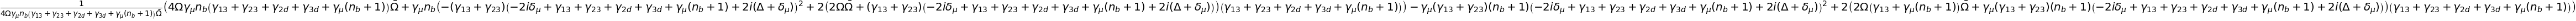

In [328]:
sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del}))

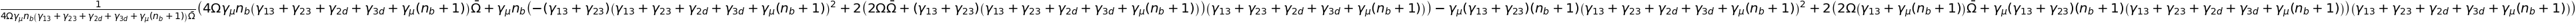

In [880]:
sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del})).subs({Del:0})

In [908]:
E_eq=sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del})-sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del})).subs({Del:0})).subs({Omega*sym.conjugate(Omega):Wsq})/Del**2

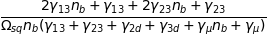

In [909]:
E_eq

In [910]:
D_eq=sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del}).subs({Del:0}).subs({Omega*sym.conjugate(Omega):Wsq}))

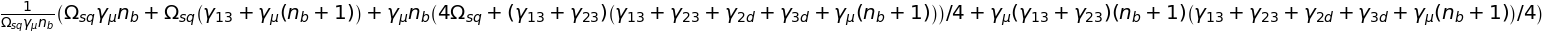

In [911]:
D_eq

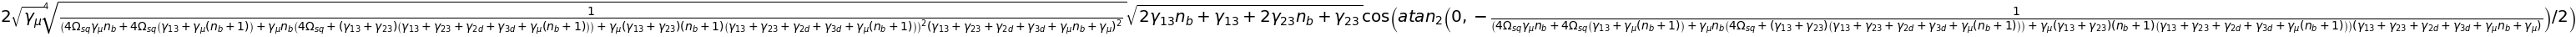

In [912]:
sym.re(sym.simplify(sym.sqrt(-E_eq/D_eq)))

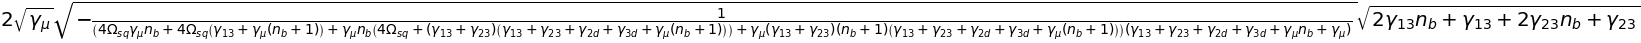

In [913]:
sym.simplify(sym.sqrt(-E_eq/D_eq))

In [879]:
sym.simplify(rho_simp/sym.simplify(rho_simp[0]+rho_simp[4] +rho_simp[8]))

⎡                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                      _           ⎛          
⎢4⋅Ω⋅γₘᵤ⋅n_b⋅(γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 1))⋅Ω - γₘᵤ⋅n_b⋅⎝(γ₁₃ + γ₂₃
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [354]:
def test_fun(x):
    reval=np.array([x,x**2])
    return reval

In [356]:
test_fun(4)

array([ 4, 16])

In [360]:
scipy.integrate.fixed_quad(test_fun,1,3,n=10)

(array([4.        , 8.66666667]), None)

In [361]:
scipy.integrate.quadrature(test_fun,1,3)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [635]:
rho_0u=sym.simplify(L0.nullspace()[0]).subs({2*I*delo:2*I*delm+2*I*Del})
rho_0norm=((rho_0u)/(rho_0u[0]+rho_0u[4]+rho_0u[8]))
rho_0norm_lam1=sym.lambdify((Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega),rho_0norm)
def rho_0norm_lam(Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega):
    return np.stack(rho_0norm_lam1(Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega))[:,0]


In [754]:
(rho_0norm_lam(10.9,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega']))

array([3.51052580e-01+0.0000000e+00j, 0.00000000e+00+0.0000000e+00j,
       0.00000000e+00+0.0000000e+00j, 0.00000000e+00+0.0000000e+00j,
       3.24504177e-01+0.0000000e+00j, 3.26482874e-10+2.9968895e-05j,
       0.00000000e+00+0.0000000e+00j, 3.26482874e-10-2.9968895e-05j,
       3.24443243e-01+0.0000000e+00j])

In [584]:
rho_0norm

⎡                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢            ⎛                                                                
⎢            ⎜    - (γ₁₃ + γ₂₃)⋅(2⋅ⅈ⋅Δ + γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 
⎢4⋅Ω⋅γₘᵤ⋅n_b⋅⎜1 + ────────────────────────────────────────────────────────────
⎢            ⎜                                                                
⎢            ⎝                                                                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [561]:
np.nonzero([val1!=0 for val1 in rho_0norm])


(array([0, 4, 5, 7, 8]),)

In [667]:
test_fun =  lambda x : [p['gamma13']/(p['gamma13']-1j*x), p['gamma13']/(p['gamma23']-1j*x) ]

In [670]:
test_fun(10.9).real[0]

AttributeError: 'list' object has no attribute 'real'

In [711]:
def test_integrate(p):
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    print(muD)
    print(sdD)
    rho_0norm_fun=lambda Delvals: np.array(test_fun(Delvals))
    
    gaussfun=lambda Delvals:1/np.sqrt(2*np.pi)/sdD*np.exp(-(Delvals-muD)**2/(2*sdD**2))#*rho_0norm_fun(Delvals)
    func_to_int=lambda Delvals: rho_0norm_fun(Delvals)*gaussfun(Delvals)
    #print(func_to_int(10.6))
    #print(gaussfun(10.6))
    rho0_int=np.zeros(2,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in range(2):#[0, 4, 5, 7, 8]:
        Rfun=lambda Delvals: np.real(func_to_int(Delvals)[ii])
        Ifun=lambda Delvals: np.imag(func_to_int(Delvals)[ii])
     #   print(Rfun(10.3))
        rho0_int[ii]=scipy.integrate.quad(Rfun,-np.inf,np.inf,limit=100)[0]+1j*scipy.integrate.quad(Ifun,-np.inf,np.inf,limit=100)[0]
        #rho0_int= Rfun(10.3)+1j*Ifun(10.3)
    return rho0_int

In [713]:
test_integrate(p)
5400000.0
458441484.36017835

5400000.0
458441484.36017835


In [715]:
p['mean_delao']-p['mean_delam'],np.sqrt(p['sd_delam']**2+p['sd_delao']**2)

In [708]:
def test_integrate_bad(p):
    rho_0norm_fun=lambda delovals,delmvals: np.array(test_fun(delovals-delmvals))
    func_to_int=lambda delovals,delmvals:1/(2*np.pi)/p['sd_delao']/p['sd_delam']*np.exp(-(delovals-p['mean_delao'])**2/(2*p['sd_delao']**2))*np.exp(-(delmvals-p['mean_delam'])**2/(2*p['sd_delam']**2))*rho_0norm_fun(delovals,delmvals)
    rho0_int=np.zeros(2,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in range(2):#[0, 4, 5, 7, 8]:
        Rfun=lambda delovals,delmvals: func_to_int(delovals,delmvals).real[ii]
        Ifun=lambda delovals,delmvals: func_to_int(delovals,delmvals).imag[ii]
        rho0_int[ii]=scipy.integrate.nquad(Rfun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]+1j*scipy.integrate.nquad(Ifun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]
    return rho0_int


In [710]:
test_integrate_bad(p)

array([1.68155327e-11-3.87576513e-20j, 8.51216767e-12-3.84232595e-20j])

In [752]:
import quadpy

ModuleNotFoundError: No module named 'quadpy'

In [1076]:
muD=p['mean_delao']-p['mean_delam']
sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
sdX=2*p['sd_delam']*p['sd_delao']/np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
muX=lambda Del : 1/np.sqrt(p['sd_delam']**2+p['sd_delao']**2)*(p['sd_delao']**2*(Del+2*p['sd_delam'])-p['sd_delam']**2*(Del-2*p['sd_delao']))
gauss_fun=lambda del1, del2, m1,m2,sd1,sd2: 1.0/(2*pi*sd1*sd2)*np.exp(-(del1-m1)**2/(2*sd1**2)
                                                                  -(del2-m2)**2/(2*sd2**2))

gauss_fun1d=lambda del1, m1,sd1: 1/np.sqrt(2*np.pi)*1/sd1*np.exp(-(del1-m1)**2/(2*sd1**2))

G_om=lambda del1, del2:gauss_fun(del1,del2,p['mean_delao'],p['mean_delam'],p['sd_delao'],p['sd_delam'])
G_DX=lambda chi,Del : gauss_fun(Del,chi,muD,muX(Del),sdD,sdX)
G_D=lambda Del: scipy.integrate.quad(G_DX,-np.inf,np.inf, args=(Del))[0]
G_D2=lambda Del:1/np.sqrt(2*np.pi)*1/sdD*np.exp(-(Del-muD)**2/(2*sdD**2))
G_X=lambda chi,Del:1/np.sqrt(2*np.pi)*1/sdX*np.exp(-(chi-muX(Del))**2/(2*sdX**2))
G_X2=lambda chi,Del:gauss_fun1d(chi,muX(Del), sdX)
G_o=lambda del1: gauss_fun1d(del1,p['mean_delao'],p['sd_delao'])
G_m=lambda del1: gauss_fun1d(del1,p['mean_delam'],p['sd_delam'])

#scipy.integrate.nquad(G_om,[[-np.inf,np.inf],[-np.inf,np.inf]]),scipy.integrate.nquad(G_DX,[[-np.inf,np.inf],[-np.inf,np.inf]]),scipy.integrate.quad(G_D,-np.inf,np.inf), scipy.integrate.quad(G_D2,-np.inf,np.inf)#scipy.integrate.quad(G_X,-np.inf,np.inf, args=(10000))
scipy.integrate.quad(G_X,-np.inf,np.inf, args=(10000)), scipy.integrate.quad(G_X2,-np.inf,np.inf, args=(10000)),scipy.integrate.quad(G_o,-np.inf,np.inf)[0]*scipy.integrate.quad(G_m,-np.inf,np.inf)[0] ,scipy.integrate.nquad(G_om,[[-np.inf,np.inf],[-np.inf,np.inf]])





/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [1015]:
def rho0_GHint(p,deg=90):
    GHx,GHweights=np.polynomial.hermite.hermgauss(deg)
    rho0_GHfun=lambda x:(rho_0norm_lam(np.sqrt(2)*x*np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
 +(p['mean_delao']-p['mean_delam']),p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega']))/np.sqrt(np.pi)
    rho0_x=np.zeros((deg,9),dtype=np.complex_)
    for ii in [0, 4, 5, 7, 8]:

        rho0_x[:,ii]=rho0_GHfun(GHx)[ii]
    #print(rho0_x[])
    #print(GHx.shape)
    return np.matmul(GHweights[None,:],rho0_x)
    

In [1014]:
n=185
rho0_GHint(p,300), rho0_GHint(p,185*2)

(array([[4.78308054e-01-7.40345484e-20j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         4.53463965e-01+7.61991875e-20j, 4.26203946e-06+6.30223386e-06j,
         0.00000000e+00+0.00000000e+00j, 4.26203946e-06-6.30223386e-06j,
         6.82279808e-02-2.16463916e-21j]]),
 array([[4.78262688e-01+2.10896004e-20j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         4.53417992e-01-1.94312121e-20j, 4.55041045e-06+6.31067083e-06j,
         0.00000000e+00+0.00000000e+00j, 4.55041045e-06-6.31067083e-06j,
         6.83193195e-02-1.65838827e-21j]]))

In [1016]:
rho0_integrate_2d(0,0,p)

array([ 1.43990456e-11+6.89860466e-44j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        1.33101156e-11-7.14581008e-44j, -2.55577841e-26+1.22922750e-15j,
        0.00000000e+00+0.00000000e+00j, -2.55577841e-26-1.22922750e-15j,
        1.33076163e-11+2.47205379e-45j])

In [649]:
 rho_0norm_lam(0,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])

array([ 0.35105258+0.0000000e+00j,  0.        +0.0000000e+00j,
        0.        +0.0000000e+00j,  0.        +0.0000000e+00j,
        0.32450418+0.0000000e+00j, -0.        +2.9968895e-05j,
        0.        +0.0000000e+00j, -0.        -2.9968895e-05j,
        0.32444324+0.0000000e+00j])

In [842]:
def rho0_integrate(p):
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    rho_0norm_fun=lambda Delvals: rho_0norm_lam(Delvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda Delvals:1/np.sqrt(2*np.pi)/sdD*np.exp(-(Delvals-muD)**2/(2*sdD**2))*rho_0norm_fun(Delvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    print('     ' + str(func_to_int(10.9).shape))
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in range(9):#[0, 4, 5, 7, 8]:
        Rfun=lambda Delvals: func_to_int(Delvals)[ii].real
        Ifun=lambda Delvals: func_to_int(Delvals)[ii].imag
        rho0_int[ii]=scipy.integrate.quad(Rfun,-np.inf,np.inf,limit=10000)[0]+1j*scipy.integrate.quad(Ifun,-np.inf,np.inf,limit=10000)[0]
    return rho0_int

In [843]:
rho0_integrate(p)

     (9,)


/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


array([-6.10939482e-10+1.54540560e-40j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -5.64737094e-10+1.48814738e-40j,  3.68045792e-22+7.28196634e-11j,
        0.00000000e+00+0.00000000e+00j,  3.68045792e-22-7.28196634e-11j,
       -5.64631049e-10-3.03355297e-40j])

In [863]:
def rho0_integrate_2d(delo,delm,p):
    rho_0norm_fun=lambda delovals,delmvals: rho_0norm_lam(delovals-delmvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda delovals,delmvals:1/(2*np.pi)/p['sd_delao']/p['sd_delam']*np.exp(-(delovals-delo-p['mean_delao'])**2/(2*p['sd_delao']**2))*np.exp(-(delmvals-delm-p['mean_delam'])**2/(2*p['sd_delam']**2))*rho_0norm_fun(delovals,delmvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in [0, 4, 5, 7, 8]:
        Rfun=lambda delovals,delmvals: func_to_int(delovals,delmvals)[ii].real
        Ifun=lambda delovals,delmvals: func_to_int(delovals,delmvals)[ii].imag
        rho0_int[ii]=scipy.integrate.nquad(Rfun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]+1j*scipy.integrate.nquad(Ifun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]
    return rho0_int


In [845]:
rho0_integrate_bad(p)

array([ 1.43990456e-11+6.89860466e-44j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        1.33101156e-11-7.14581008e-44j, -2.55577841e-26+1.22922750e-15j,
        0.00000000e+00+0.00000000e+00j, -2.55577841e-26-1.22922750e-15j,
        1.33076163e-11+2.47205379e-45j])

In [861]:
def rho0_integrate_bad2(p):
    
    
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    sdX=2*p['sd_delao']*p['sd_delam']/np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    muX=lambda Delv: 1/(p['sd_delam']**2+p['sd_delao']**2)*(p['sd_delao']**2*(Delv+2*p['mean_delam'])-p['sd_delam']**2*(Delv-2*p['mean_delao']))
    rho_0norm_fun=lambda Delvals: rho_0norm_lam(Delvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda Delvals, chivals:1/(2*np.pi*sdD*sdX)*np.exp(-(Delvals-muD)**2/(2*sdD**2))*np.exp(-(chivals-muX(Delvals))**2/(2*sdX**2))*rho_0norm_fun(Delvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in [0, 4, 5, 7, 8]:
        Rfun=lambda delovals,delmvals: func_to_int(delovals,delmvals).real[ii]
        Ifun=lambda delovals,delmvals: func_to_int(delovals,delmvals).imag[ii]
        rho0_int[ii]=scipy.integrate.nquad(Rfun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]+1j*scipy.integrate.nquad(Ifun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]
    return rho0_int

In [871]:
rho0_integrate_2d(0,0,p)[:].shape

In [1046]:
def find_rhoint(deloval,delmval,p):
    rho0=rho0_integrate_2d(deloval,delmval,p)[:,None]
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    Lb_mat=La_fun(p['go'],p['gm'])
    rhoa=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0)
    rhob=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0)
    #rhoa=-np.matmul(np.matmul(np.linalg.inv(L0_mat),La_mat),rho0)
    #rhob=-np.matmul(np.matmul(np.linalg.inv(L0_mat),Lb_mat),rho0)
    return rho0, np.array(rhoa), np.array(rhob)

In [1043]:
find_rhoint(10,100,p)

(array([[ 1.43990454e-11+6.90006843e-44j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 1.33101154e-11-7.14732630e-44j],
        [-2.55632070e-26+1.22922748e-15j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-2.55632070e-26-1.22922748e-15j],
        [ 1.33076161e-11+2.47257840e-45j]]),
 array([[-0.00000000e+00-0.00000000e+00j],
        [ 5.66166465e-17-6.32332222e-21j],
        [ 5.06782555e-21-5.75092860e-17j],
        [ 5.66166465e-17+6.32332222e-21j],
        [-0.00000000e+00-0.00000000e+00j],
        [-0.00000000e+00-0.00000000e+00j],
        [ 5.06782555e-21+5.75092860e-17j],
        [-0.00000000e+00-0.00000000e+00j],
        [-0.00000000e+00-0.00000000e+00j]]),
 array([[-0.00000000e+00-0.00000000e+00j],
        [ 5.66166465e-17-6.32332222e-21j],
        [ 5.06782555e-21-5.75092860e-17j],
        [ 5.66166465e-17+6.32332222e-21j],
        [-0.00000000e+00-0.00000000e+00j],
       

In [1047]:
find_rhoint(10,100,p)

(array([[ 1.43990454e-11+6.90006843e-44j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 1.33101154e-11-7.14732630e-44j],
        [-2.55632070e-26+1.22922748e-15j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-2.55632070e-26-1.22922748e-15j],
        [ 1.33076161e-11+2.47257840e-45j]]),
 array([[0.00000000e+00+0.00000000e+00j],
        [5.66166465e-17-6.32332222e-21j],
        [5.06782555e-21-5.75092860e-17j],
        [5.66166465e-17+6.32332222e-21j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j],
        [5.06782555e-21+5.75092860e-17j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j]]),
 array([[0.00000000e+00+0.00000000e+00j],
        [5.66166465e-17-6.32332222e-21j],
        [5.06782555e-21-5.75092860e-17j],
        [5.66166465e-17+6.32332222e-21j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+

In [927]:
L0.subs({delo:0,delm:0})

⎡-γₘᵤ⋅n_b                 0                               0                   
⎢                                                                             
⎢            γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                 _                 
⎢   0      - ──── - ─────── - ─────────────              -ⅈ⋅Ω                 
⎢             2        2            2                                         
⎢                                                                             
⎢                                              γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b     
⎢   0                    -ⅈ⋅Ω                - ─── - ─── - ──── - ───────     
⎢                                               2     2     2        2        
⎢                                                                             
⎢                                                                            γ
⎢   0                     0                               0                - ─
⎢                                                   

In [982]:
Del_test=np.linspace(-6e8,6e8,101)


rho_test=rho_0norm_lam(Del_test,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
rho_test

array([array([0.50868596+0.00000000e+00j, 0.50854455-4.82185671e-21j,
       0.50839448+1.33553116e-19j, 0.50823505+0.00000000e+00j,
       0.50806546+0.00000000e+00j, 0.50788484+1.51618600e-19j,
       0.50769223+1.51978788e-19j, 0.50748655-1.58856429e-19j,
       0.5072666 +0.00000000e+00j, 0.50703105+1.81966681e-19j,
       0.50677841-1.90966906e-19j, 0.506507  -2.00645866e-19j,
       0.50621494+2.11072908e-19j, 0.50590012-2.22326366e-19j,
       0.50556014+0.00000000e+00j, 0.50519229+2.47679620e-19j,
       0.5047935 +2.61995206e-19j, 0.50436026+0.00000000e+00j,
       0.50388857+1.39128562e-19j, 0.50337383+1.65543392e-19j,
       0.50281076-9.90930925e-21j, 0.50219327-1.77947353e-19j,
       0.50151429+1.90286515e-19j, 0.50076562+1.36812428e-20j,
       0.49993769+4.22758738e-19j, 0.49901926+0.00000000e+00j,
       0.49799716+2.54731480e-19j, 0.49685579+0.00000000e+00j,
       0.49557669+2.73754916e-19j, 0.49413788+0.00000000e+00j,
       0.49251308-3.56981250e-19j, 0.49067078+3.

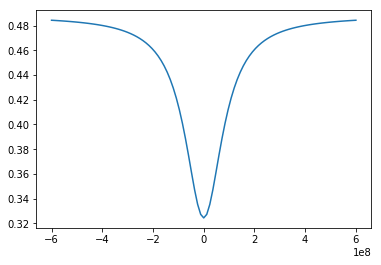

In [958]:
plt.plot(Del_test,np.abs(rho_test[4]))

In [985]:
rho[]

In [983]:
for ii in [0,4,5,7,8]:
    print(rho_test[ii][50])

(0.3510525800824311+0j)
(0.3245041771371065+0j)
(-0+2.996889497337545e-05j)
(-0-2.996889497337545e-05j)
(0.32444324278046244+0j)


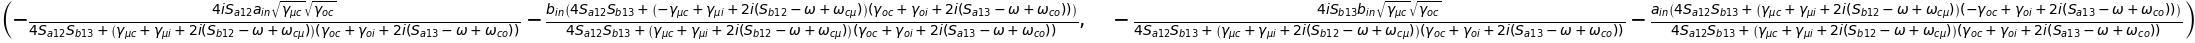

In [1102]:
A,B,C,D,F,G =sym.symbols('A B C D F G')
a_in,a_out,b_in,b_out=sym.symbols('a_in a_out b_in b_out')

Sb12,Sa12=sym.symbols('S_b_1_2 S_a_1_2')
Sb13,Sa13=sym.symbols('S_b_1_3 S_a_1_3')
w, wcm,wco=sym.symbols('omega omega_c_mu omega_c_o',Real=True) 
gammi,gammc,gamoi,gamoc=sym.symbols('gamma_mu_i gamma_mu_c gamma_o_i gamma_o_c',positive = True, Real=True)

in_mat=Matrix([[A,-C],[G,-D]])
out_mat=Matrix([[-B,C],[-G,F]])

A_eq=(I*(wcm+Sb12-w)+(gammi-gammc)/2)
B_eq=(I*(wcm+Sb12-w)+(gammi+gammc)/2)
C_eq=-I*Sa12*sym.sqrt(gammc/gamoc)
D_eq=(I*(wco+Sa13-w)+(gamoi-gamoc)/2)
F_eq=(I*(wco+Sa13-w)+(gamoi+gamoc)/2)
G_eq=-I*Sb13*sym.sqrt(gamoc/gammc)

out_mat_eq=sym.simplify((out_mat.inv()*in_mat).subs({A:A_eq,B:B_eq,C:C_eq,D:D_eq,F:F_eq,G:G_eq}))*Matrix([[b_in],[a_in]])
bout_eq=out_mat_eq[0]
aout_eq=out_mat_eq[1]
bout_eq, aout_eq

$b_{out}=C_{ab}a_{in}+C_{bb}b_{in}$


$a_{out}=C_{aa}a_{in}+C{ba}b_{in}$

In [1103]:
Cab=bout_eq.subs({b_in:0})/a_in
Cbb=bout_eq.subs({a_in:0})/b_in
Caa=aout_eq.subs({b_in:0})/a_in
Cba=aout_eq.subs({a_in:0})/b_in

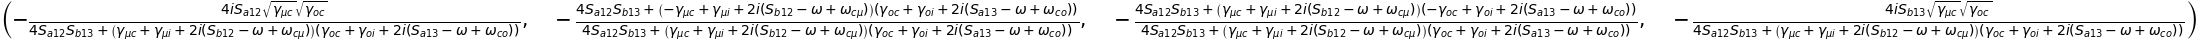

In [1104]:
Cab,Cbb,Caa,Cba

In [1105]:
print('C_{ab}=&'+sym.latex(Cab)+'\\\\')
print('C_{bb}=&'+sym.latex(Cbb)+'\\\\')
print('C_{aa}=&'+sym.latex(Caa)+'\\\\')
print('C_{ba}=&'+sym.latex(Cba))


C_{ab}=&- \frac{4 i S_{a 1 2} \sqrt{\gamma_{\mu c}} \sqrt{\gamma_{o c}}}{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}\\
C_{bb}=&- \frac{4 S_{a 1 2} S_{b 1 3} + \left(- \gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}\\
C_{aa}=&- \frac{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(- \gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}{4 S_{a 1 2}

In [1106]:
Cab_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cab)
Cbb_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cbb)
Caa_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Caa)
Cba_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cba)

In [1107]:
def convert_coeffs(wval,deloval,delmval,p):
    rho0int, rhoaint, rhobint= find_rhoint(deloval,delmval,p)
    Sa12_val=p['gm']*p['Nm']*rhoaint[3]
    Sa13_val=p['go']*p['No']*rhoaint[6]
    Sb12_val=p['gm']*p['Nm']*rhobint[3]
    Sb13_val=p['go']*p['No']*rhobint[6]
    Cab_val=(Cab_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cbb_val=(Cbb_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Caa_val=(Caa_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cba_val=(Cba_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    return Cab_val, Cbb_val, Caa_val, Cba_val

In [1108]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 1,
 'gammamu': 47.61904761904761,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 600000.0,
 'sd_delam': 66700480.96793615,
 'mean_delao': 6000000.0,
 'sd_delao': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+16,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 439822.971502571,
 'gammami': 4084070.449666731,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': -492090.88755145477}

In [1176]:
start_time=time.time()
wvals=np.linspace(-6e8,6e8,5)
Cab_vals=np.zeros(len(wvals),dtype=np.complex_)
Cbb_vals=np.zeros(len(wvals),dtype=np.complex_)
Caa_vals=np.zeros(len(wvals),dtype=np.complex_)
Cba_vals=np.zeros(len(wvals),dtype=np.complex_)
for ii,wval in enumerate(wvals):
    Cab_vals[ii], Cbb_vals[ii], Caa_vals[ii], Cba_vals[ii]=convert_coeffs(wval,10e4,-4e4,p)
    elapsed_time=time.time()-start_time
    print('  Time: ' + str(elapsed_time))


  Time: 6.3138344287872314
  Time: 12.616917848587036
  Time: 18.972618341445923
  Time: 25.486801147460938
  Time: 31.83413863182068


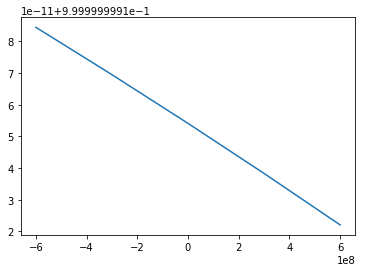

In [1180]:
plt.plot(wvals,np.abs(Cbb_vals))

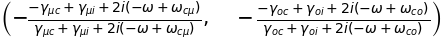

In [1184]:
Cbb_noatoms=Cbb.subs({Sa12:0,Sa13:0,Sb12:0,Sb13:0})
Caa_noatoms=Caa.subs({Sa12:0,Sa13:0,Sb12:0,Sb13:0})
Cbb_noatoms, Caa_noatoms

In [1185]:
L0

⎡-γₘᵤ⋅n_b                     0                                     0         
⎢                                                                             
⎢                   γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                    _       
⎢   0      -ⅈ⋅δₘᵤ - ──── - ─────── - ─────────────                 -ⅈ⋅Ω       
⎢                    2        2            2                                  
⎢                                                                             
⎢                                                           γ₁₃   γ₂₃   γ_3d  
⎢   0                       -ⅈ⋅Ω                    -ⅈ⋅δₒ - ─── - ─── - ──── -
⎢                                                            2     2     2    
⎢                                                                             
⎢                                                                             
⎢   0                         0                                     0         
⎢                                                   